## 0. Parameters and Initialization ##

In [1]:
%matplotlib inline  
%pylab
%matplotlib inline  


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.io import loadmat, savemat
from util import mosaic, status_check
import matplotlib.pyplot as plt
from numpy.ma import masked_array
from skimage.filters import threshold_otsu
import time
import dcemri
import dicom


# SCRIPT FLAGS
plotting = True
Rel = 4.5   # Relaxivity of Gd-DTPA at 3 T [s^-1 [mmol Gd-DTPA]^{-1}]   
flip_angle = 30 * pi / 180.0 # rad
TR = 5e-3   # sec
nx = 80
ny = 50
nt = 1321

data_dir = 'qiba/v6'
file_ext = 'QIBA_v06_Tofts_beta1'

/usr/local/lib/python3.6/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
# add cubehelix3 color map
mpl.cm.register_cmap(name='cubehelix3', data=mpl._cm.cubehelix(gamma=1.0, s=0.4, r=-0.5, h=1.5))

## 1. Load data ##

In [4]:
data_dicom = zeros((nt, nx, ny))
T1map = ones((nx, ny)) # s

t = 0.5*arange(nt)  # ms

for k in range(nt):
    file_name = '%s/%s_%04d.dcm' % (data_dir, file_ext, k+1)
    dcm = dicom.read_file(file_name)
    data_dicom[k,:,:] = dcm.pixel_array.astype('float')
    #print k, dcm.pixel_array.shape, file_name
    
data_dce = data_dicom[:,10:70,:]
nt, nx, ny = data_dce.shape
S0map = ones((nx, ny)) * 50000.0 #
data_aif = mean(mean(data_dicom[:,70:,:], axis=2), axis=1)

In [5]:
# subsample data to speed up the run
deltat = 2
data_dce = data_dce[::deltat,:,:]
data_aif = data_aif[::deltat]   # TODO: do this better
t = t[::deltat]
nt = len(t)

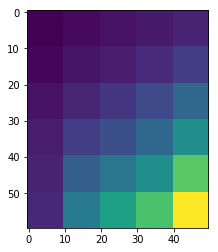

In [6]:
imshow(data_dce[:,:,:].max(axis=0), interpolation='nearest')

Text(0.5,1,'example tissue signal curve')

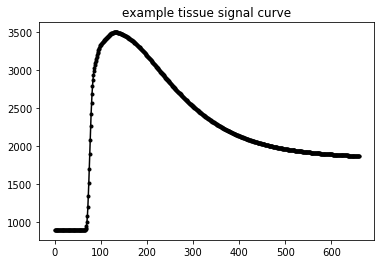

In [7]:
plot(data_dce[:,-1,-1],'k.-')
title('example tissue signal curve')

## 2. Derive the AIF ##

In [8]:
# turn Sb into Cp
T1p = 1.440
R1p = 1 / T1p
Hct = 0.45
S0 = data_aif[:4].mean()
R1_eff_aif = dcemri.dce_to_r1eff(data_aif, S0, R1p, TR, flip_angle)
Cb = dcemri.r1eff_to_conc(R1_eff_aif.flatten(), R1p, Rel)  
Cp = Cb.flatten() / (1.0 - Hct)

converting DCE signal to effective R1
converting effective R1 to tracer tissue concentration


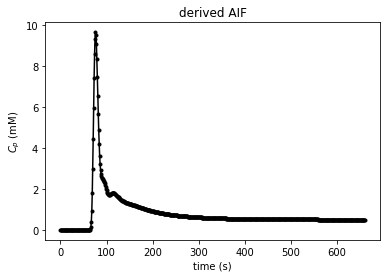

In [9]:
if plotting:
    figure(1)
    clf()
    plot(t, Cp, 'k.-')
    xlabel('time (s)')
    ylabel('$C_p$ (mM)')
    title('derived AIF')
    savefig('qiba/qiba_v6_aif.pdf')

## 3. Reduce the problem size averaging 10x10 ROIs to single pixels. ##

In [10]:
data_dce = transpose(data_dce, (1,2,0)).copy('C')
nxx = 6
nyy = 5
data_dce_red = zeros((nxx, nyy, nt))
t1_map_red = zeros((nxx, nyy))
s0_map_red = zeros((nxx, nyy))
for x in range(nxx):
    for y in range(nyy):
        tmp = data_dce[10*x:10*(x+1), 10*y:10*(y+1), :]
        data_dce_red[x,y,:] = mean(mean(tmp, axis=0), axis=0)
        tmp = T1map[10*x:10*(x+1), 10*y:10*(y+1)]
        t1_map_red[x,y] = mean(tmp)
data_dce = data_dce_red
T1map = t1_map_red
nx = nxx
ny = nyy

## 4. Convert signal to tissue concentration $C_t$ ##

In [11]:
R1map = 1.0 / T1map

In [13]:
data_dce = reshape(data_dce, (nx, ny, nt))
S0 = data_dce[:,:,:4].mean(axis=2)
R1_eff = dcemri.dce_to_r1eff(data_dce, S0, R1map.T, TR, flip_angle)
data_dce = reshape(data_dce, (-1, nt))
R1_eff_old = dcemri.dce_to_r1eff_old(data_dce, S0map, list(range(nx*ny)), TR, flip_angle)
data_dce = reshape(data_dce, (nx, ny, nt))
R1_eff_old = reshape(R1_eff_old, (nx, ny, nt))

converting DCE signal to effective R1


In [14]:
R1_eff_old.shape

(6, 5, 661)

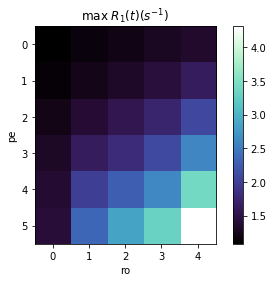

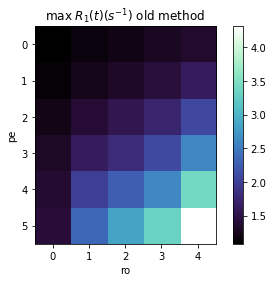

In [15]:
# show map of R1_eff 
R1_eff = reshape(R1_eff, (nx, ny, nt))
if plotting:
    figure(7)
    clf()
    imshow(mosaic(R1_eff.max(axis=2)), interpolation='nearest', cmap='cubehelix3')
    title('max $R_1(t) (s^{-1})$')
    xlabel('ro')
    ylabel('pe')
    colorbar()
    figure(8)
    clf()
    imshow(mosaic(R1_eff_old.max(axis=2)), interpolation='nearest', cmap='cubehelix3')
    title('max $R_1(t) (s^{-1})$ old method')
    xlabel('ro')
    ylabel('pe')
    colorbar()

In [16]:
# convert effecitve R1 to tissue concentration Ct
Ct = dcemri.r1eff_to_conc(transpose(R1_eff, (2,0,1)), R1map, Rel)
Ct = transpose(Ct, (1,2,0))

converting effective R1 to tracer tissue concentration


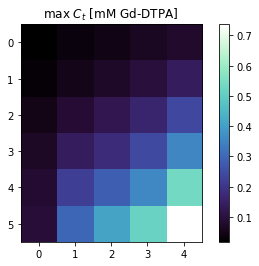

In [17]:
# show map of Ct
Ct = reshape(Ct, (nx, ny, nt))
if plotting:
    figure(9)
    clf()
    imshow(Ct.max(axis=2), interpolation='nearest', cmap='cubehelix3')
    title('max $C_t$ [mM Gd-DTPA]')
    colorbar()
    savefig('qiba/qiba_v6_Ct.pdf')
Ct = reshape(Ct, (-1, nt))

## 5. Fit voxel-wise Ct to the model to get $K^{trans}$ and $v_e$. ##

In [18]:
params, covs =  dcemri.fit_tofts_model(Ct, Cp, t, extended=False)

fitting perfusion parameters
using Standard Tofts-Kety
fitting 30 voxels
10% complete, 32 of 35 s remain
20% complete, 31 of 39 s remain
30% complete, 27 of 39 s remain
40% complete, 22 of 38 s remain
50% complete, 19 of 38 s remain
60% complete, 14 of 36 s remain
70% complete, 11 of 36 s remain
80% complete, 7 of 36 s remain
90% complete, 3 of 35 s remain
100% complete, 0 of 35 s remain
35.27979493141174 s elapsed


In [20]:
Kt = zeros(nx*ny)
idxs_dce = range(nx*ny)
Kt[idxs_dce] = params[0]
ve = zeros(nx*ny)
ve[idxs_dce] = params[1]
Kt = reshape(Kt, (nx, ny))
ve = reshape(ve, (nx, ny))

In [21]:
# convert Kt to min$^{-1}$
Kt = Kt * 60.0

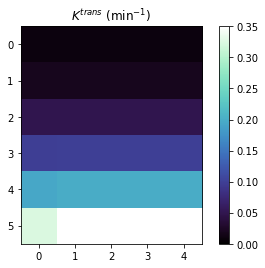

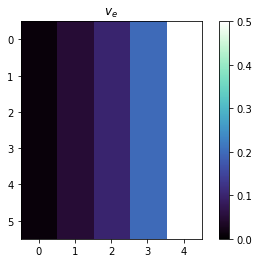

In [22]:
# PLOT RESULTS
if plotting:
    figure(13)
    clf()
    imshow(Kt, interpolation='nearest', cmap='cubehelix3', vmin=0, vmax=0.35)
    #plot(Kt.T,'o-')
    colorbar()
    title('$K^{trans}$ (min$^{-1}$)')
    savefig('qiba/qiba_v6_Kt.pdf')

    figure(14)
    clf()
    imshow(ve, interpolation='nearest', cmap='cubehelix3', vmin=0, vmax=0.5)
    #plot(ve,'o-')
    title('$v_e$')
    colorbar()
    savefig('qiba/qiba_v6_ve.pdf')

In [23]:
Kt_truth = array([0.01, 0.02, 0.05, 0.1, 0.2, 0.35])
ve_truth = array([0.01, 0.05, 0.1, 0.2, 0.5])
Kt_error = ((Kt.T - Kt_truth) / Kt.T).T
ve_error = (ve - ve_truth) / ve

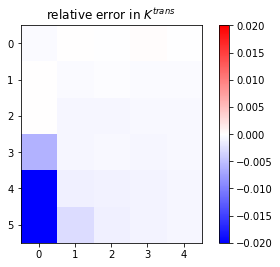

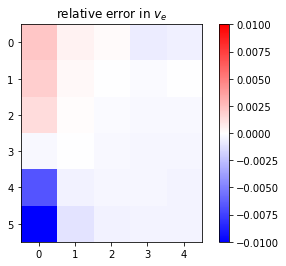

In [24]:
if plotting:
    figure(10)
    imshow(Kt_error, interpolation='nearest', cmap='bwr', vmin=-0.02, vmax=0.02)
    title('relative error in $K^{trans}$')
    colorbar()
    savefig('qiba/qiba_v6_error_Kt.pdf')

    
    figure(11)
    imshow(ve_error, interpolation='nearest', cmap='bwr', vmin=-0.01, vmax=0.01)
    title('relative error in $v_e$')
    colorbar()
    savefig('qiba/qiba_v6_error_ve.pdf')

In [26]:
# mean relative error
print ('rms relative error in Kt:', sqrt((Kt_error**2).mean()))
print ('rms relative error in ve:', sqrt((ve_error**2).mean()))

rms relative error in Kt: 0.0149482687443
rms relative error in ve: 0.00435305568822
